<a href="https://colab.research.google.com/github/65-1157/65-1157/blob/main/Dynamic-Programming-Algorithms-Codes%20/2025_10_13_14_Algoritmos_DS_DP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Algoritmos para Ciência de Dados: Greedy, Dividir-para-Conquistar e Programação Dinâmica

Este notebook combina exemplos práticos de Ciência de Dados com explicações dos paradigmas **Greedy**, **Dividir-para-Conquistar (D&C)** e **Programação Dinâmica (DP)**.

#### Agenda de aplicação dos algoritmos
- **KNN do zero** (agrupamento) em dataset sintético + **Greedy Forward Feature Selection** (aplicação direta em DS).
- KNN = algoritmo para descobrir grupos (nearest_neighbor), por meio de distância entre eles.
- **Dividir-para-Conquistar** com `merge sort` (curto, comentado). Ordenação de características numéricas.
- **Programação Dinâmica** com *coin change* (top-down + bottom-up) e **edit distance** (visualização), apontando claramente os **subproblemas sobrepostos**.

**Objetivo**: entender *como* e *quando* cada algoritmo se aplica em problemas de DS.

### agrupamento = identicar itens que façam parte do mesmo conjunto ou grupo.

In [ ]:
# Imports básicos
import numpy as np
import math
from functools import lru_cache
import matplotlib.pyplot as plt
rng = np.random.default_rng(42)


## 1) Ciência de Dados: KNN(simples) + efeito de atributos/característics confusos ou ruidosos
Criaremos um conjunto com **4 atributos/features** (2 informativos + 2 confusos/ruidosos) e usaremos um algoritmo **KNN** simples. Depois aplicaremos uma seleção **Greedy** de atributos/características.

**Feature/Característica** = atributo de registros. Exemplo, altura, peso, local de nascimento etc...

**Por quê?** Em DS, ter atributos/características irrelevantes, ou que não explicam o que precisamos saber, pode degradar o desempenho e elevar o custo de trabalho; heurísticas **gulosas** ajudam a priorizar o que mais importa rapidamente (mesmo sem ótima garantia global).

In [ ]:
# Geração de dados sintéticos
n_samples = 500
X_signal = rng.normal(0, 1, size=(n_samples, 2))
y = (X_signal[:, 0] + 0.6*X_signal[:, 1] > 0).astype(int)
X_noise = rng.normal(0, 1.4, size=(n_samples, 2))
X = np.concatenate([X_signal, X_noise], axis=1)

### Método supervisionado = divisão dos inputs em dois grupos: treino e teste. Treino são registros usados para treinar o algoritmo. Teste são registros apuram a métrica de desempenho do algoritmo.

In [ ]:
# Embaralha e separa treino/teste
idx = rng.permutation(n_samples)
X, y = X[idx], y[idx]
split = int(0.7 * n_samples)
X_train, y_train = X[:split], y[:split]
X_test,  y_test  = X[split:], y[split:]
X.shape, y.shape

((500, 4), (500,))

In [ ]:
# KNN do zero (Euclidiano) -- usando distâncias entre itens para identificar grupos
def knn_predict(X_train, y_train, X_query, k=7):
    # Distâncias para cada amostra de consulta em relação a todas do treino
    # metodo = broadcasting & numpy - tratamento de arrays e suas dimensões
    dists = np.sqrt(((X_train[None, :, :] - X_query[:, None, :]) ** 2).sum(axis=2))
    # Índices dos k vizinhos mais próximos por amostra
    neigh_idx = np.argpartition(dists, kth=k-1, axis=1)[:, :k]
    votes = y_train[neigh_idx]
    preds = (votes.mean(axis=1) >= 0.5).astype(int)
    return preds

def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

y_pred_base = knn_predict(X_train, y_train, X_test, k=5)
acc_base = accuracy(y_test, y_pred_base)
print(f"Acurácia KNN (todas as 5 features): {acc_base:.3f}")


Acurácia KNN (todas as 5 features): 0.907


### 1.1) Greedy - seleção de característica/feature (guloso)
**Ideia:** começar com zero atributos/características e **adicionar aquele** que ** melhora mais intensamente** a acurácia de validação.
**Observação:** é uma estratégia gulosa — rápida, simples — **sem** garantia de ótimo global.


Atributos selecionados (índices): [0, 1]
Melhor acurácia (validação): 0.986
Acurácia no teste (seleção gulosa): 0.973


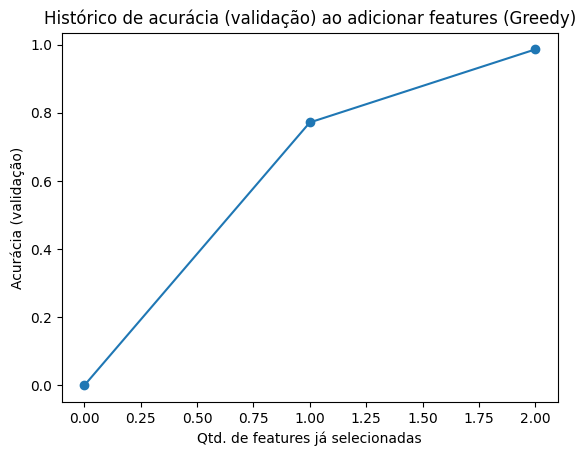

In [ ]:
def greedy_forward_selection(X_train, y_train, X_val, y_val, k=5, tol=1e-6):
    n_features = X_train.shape[1]
    selected = []
    remaining = list(range(n_features))
    history = []  # (num_features, acc)
    best_acc = 0.0

    while remaining:
        best_feat, best_try = None, best_acc
        for f in remaining:
            trial_feats = selected + [f]
            y_pred = knn_predict(X_train[:, trial_feats], y_train, X_val[:, trial_feats], k=k)
            acc = accuracy(y_val, y_pred)
            if acc > best_try + tol:
                best_try = acc
                best_feat = f
        history.append((len(selected), best_acc))
        if best_feat is None:
            break
        selected.append(best_feat)
        remaining.remove(best_feat)
        best_acc = best_try
    return selected, best_acc, history

# Split interno para validação
split_inner = int(0.8 * len(X_train))
X_tr, y_tr = X_train[:split_inner], y_train[:split_inner]
X_val, y_val = X_train[split_inner:], y_train[split_inner:]

selected_feats, best_val_acc, hist = greedy_forward_selection(X_tr, y_tr, X_val, y_val, k=7)
print('Atributos selecionados (índices):', selected_feats)
print(f"Melhor acurácia (validação): {best_val_acc:.3f}")

# Avalia no teste usando só as features escolhidas
y_pred_sel = knn_predict(X_train[:, selected_feats], y_train, X_test[:, selected_feats], k=7)
acc_sel = accuracy(y_test, y_pred_sel)
print(f"Acurácia no teste (seleção gulosa): {acc_sel:.3f}")

# Visualização simples do progresso (sem cores específicas)
steps = [h[0] for h in hist]
accs  = [h[1] for h in hist]
plt.figure()
plt.plot(steps, accs, marker='o')
plt.title('Histórico de acurácia (validação) ao adicionar features (Greedy)')
plt.xlabel('Qtd. de features já selecionadas')
plt.ylabel('Acurácia (validação)')
plt.show()


**Assuntos sugeridos para pesquisa complementar em DS:**
- Greedy para *feature ranking* inicial em pipelines rápidos.
- Em árvores de decisão, cada *split* local é uma decisão **gulosa** (ganho de informação/impureza).

## 2) Dividir-para-Conquistar: `merge sort` (curto)
**Padrão:** quebrar → resolver (recursivo) → combinar. Útil em ordenações de pré-processamento, *joins* eficientes e seleção de estatísticas (mediana/quantis) via rotinas similares.

In [ ]:
def merge(left, right):
    out, i, j = [], 0, 0
    while i < len(left) and j < len(right):
        if left[i] <= right[j]:
            out.append(left[i]); i += 1
        else:
            out.append(right[j]); j += 1
    out.extend(left[i:]); out.extend(right[j:])
    return out

def merge_sort(arr):
    if len(arr) <= 1:
        return arr
    mid = len(arr)//2
    left = merge_sort(arr[:mid])
    right = merge_sort(arr[mid:])
    return merge(left, right)

exemplo = rng.integers(0, 100, size=12).tolist()
print('Original:', exemplo)
print('Ordenado :', merge_sort(exemplo))


Original: [14, 80, 87, 21, 60, 57, 13, 45, 69, 96, 84, 9]
Ordenado : [9, 13, 14, 21, 45, 57, 60, 69, 80, 84, 87, 96]


## 3) Programação Dinâmica (DP): subproblemas sobrepostos (aplicação direta em DS)
**O que são subproblemas sobrepostos?** São **tarefas menores** que **se repetem** em ramos diferentes da solução.

**Casos típicos em DS:**
- **Edit distance** (*fuzzy matching*, limpeza/deduplicação): subproblema `dp[i][j]` = custo para transformar `A[:i]` em `B[:j]`.
- **Dynamic Time Warping** (séries temporais): subproblema `dp[i][j]` = custo de alinhar prefixos das séries até `(i, j)`.
- **Viterbi (HMM/NLP)**: subproblema `dp[t][s]` = melhor escore até tempo `t` no estado `s`.
- **Coin change / Knapsack**: subproblema `dp[t]` (ou `dp[i][t]`) = melhor solução para alvo `t` usando moedas/itens até `i`.


In [ ]:
# Coin Change — comparando guloso, top-down (memo) e bottom-up
def coin_change_greedy(coins, T):
    coins = sorted(coins, reverse=True)
    used, remaining = [], T
    for c in coins:
        while remaining >= c:
            remaining -= c; used.append(c)
    return None if remaining else used

@lru_cache(maxsize=None)
def coin_change_topdown(T, coins_tuple):
    coins = list(coins_tuple)
    if T == 0:
        return 0
    if T < 0:
        return math.inf
    best = math.inf
    for c in coins:
        best = min(best, 1 + coin_change_topdown(T - c, coins_tuple))
    return best

def coin_change_bottomup(coins, T):
    dp = [math.inf]*(T+1); dp[0] = 0
    choice = [-1]*(T+1)
    for t in range(1, T+1):
        for c in coins:
            if t-c >= 0 and dp[t-c] + 1 < dp[t]:
                dp[t] = dp[t-c] + 1
                choice[t] = c
    if dp[T] == math.inf:
        return math.inf, []
    used, cur = [], T
    while cur > 0:
        c = choice[cur]
        used.append(c)
        cur -= c
    return dp[T], used

coins = [1,3,4]; T = 6
print('Guloso ->', coin_change_greedy(coins, T))
print('Top-down (memo) mínimo de moedas ->', coin_change_topdown(T, tuple(coins)))
print('Bottom-up ->', coin_change_bottomup(coins, T))


Guloso -> [4, 1, 1]
Top-down (memo) mínimo de moedas -> 2
Bottom-up -> (2, [3, 3])


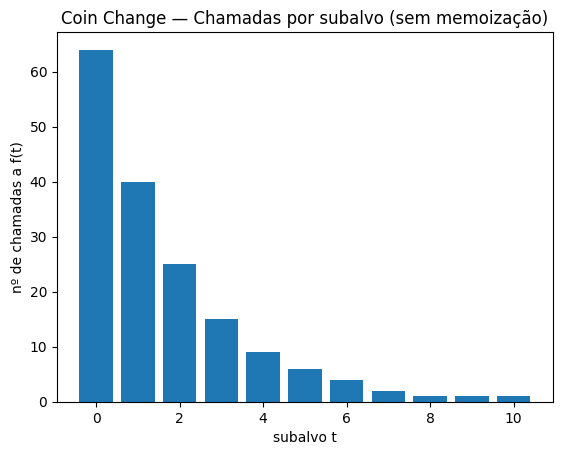

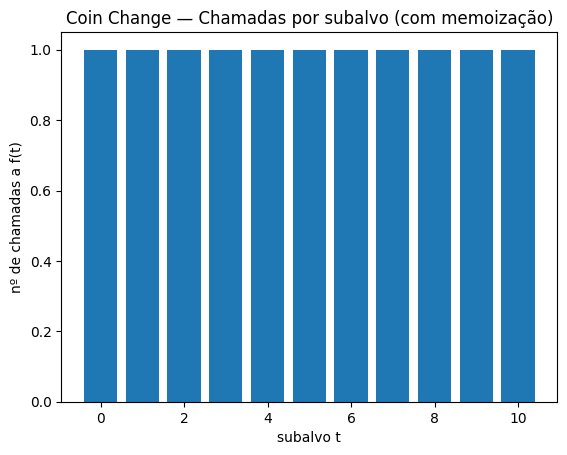

In [ ]:
# Visualização de subproblemas sobrepostos: número de chamadas por subalvo t
def count_calls_naive(T, coins):
    counts = {t:0 for t in range(T+1)}
    def f(t):
        if t < 0: return 0
        counts[t] += 1
        if t == 0: return 1
        total = 0
        for c in coins:
            total += f(t-c)
        return total
    f(T)
    return counts

def count_calls_memo(T, coins):
    counts = {t:0 for t in range(T+1)}
    @lru_cache(maxsize=None)
    def f(t):
        if t < 0: return 0
        counts[t] += 1
        if t == 0: return 1
        total = 0
        for c in coins:
            total += f(t-c)
        return total
    f(T)
    return counts

T_view = 10; coins_view = (1,3,4)
naive = count_calls_naive(T_view, coins_view)
memo  = count_calls_memo(T_view, coins_view)

plt.figure()
plt.bar(list(naive.keys()), list(naive.values()))
plt.title('Coin Change — Chamadas por subalvo (sem memoização)')
plt.xlabel('subalvo t'); plt.ylabel('nº de chamadas a f(t)')
plt.show()

plt.figure()
plt.bar(list(memo.keys()), list(memo.values()))
plt.title('Coin Change — Chamadas por subalvo (com memoização)')
plt.xlabel('subalvo t'); plt.ylabel('nº de chamadas a f(t)')
plt.show()


### Edit distance (fuzzy matching) — matriz DP
Aplicação direta em DS: **limpeza/deduplicação** de nomes de produtos, clientes, cidades, etc. Cada célula `dp[i][j]` guarda o custo de transformar `A[:i]` em `B[:j]` — estes são os **subproblemas sobrepostos**.

Edit distance('produto', 'produtos') = 1


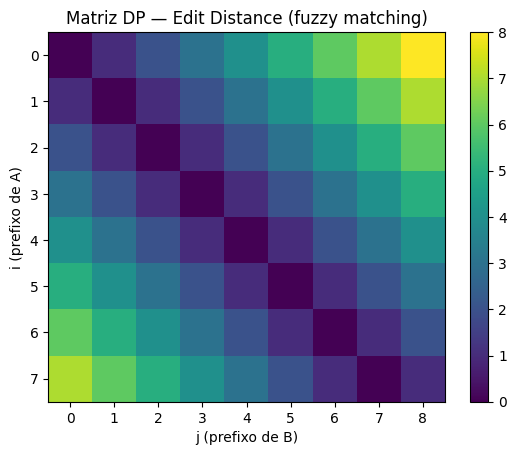

In [ ]:
def edit_distance_table(a, b):
    na, nb = len(a), len(b)
    dp = np.zeros((na+1, nb+1), dtype=int)
    for i in range(na+1): dp[i,0] = i
    for j in range(nb+1): dp[0,j] = j
    for i in range(1, na+1):
        for j in range(1, nb+1):
            cost = 0 if a[i-1] == b[j-1] else 1
            dp[i,j] = min(
                dp[i-1,j] + 1,      # remoção
                dp[i,j-1] + 1,      # inserção
                dp[i-1,j-1] + cost  # substituição
            )
    return dp

A, B = 'produto', 'produtos'
mat = edit_distance_table(A, B)
print(f"Edit distance('{A}', '{B}') = {mat[-1,-1]}")
plt.figure()
plt.imshow(mat, aspect='auto')
plt.title('Matriz DP — Edit Distance (fuzzy matching)')
plt.xlabel('j (prefixo de B)'); plt.ylabel('i (prefixo de A)')
plt.colorbar(); plt.show()


## 4) Quando usar o quê (com foco em DS)
- **Greedy**: *feature selection* rápida, heurísticas para problemas grandes; decisões locais (como splits em árvores).
- **Dividir-para-Conquistar**: ordenações e buscas eficientes, base para estruturas como KD-Tree/Ball-Tree.
- **DP**: problemas com **subproblemas sobrepostos** e **estrutura ótima** — edit distance (texto), DTW (séries), Viterbi (NLP), coin change/knapsack (orçamento de recursos).

**Ideia-chave**: avalie se há repetição natural de subpartes (DP), se a decisão local tende a ser boa (Greedy), ou se dá para quebrar e recombinar com eficiência (D&C).